Epoch: 1, Average Loss: 179.8394
Epoch: 2, Average Loss: 160.6940
Epoch: 3, Average Loss: 155.9001
Epoch: 4, Average Loss: 153.0668
Epoch: 5, Average Loss: 151.0605
Epoch: 6, Average Loss: 149.4598
Epoch: 7, Average Loss: 148.1065
Epoch: 8, Average Loss: 147.1014
Epoch: 9, Average Loss: 146.1601
Epoch: 10, Average Loss: 145.3965


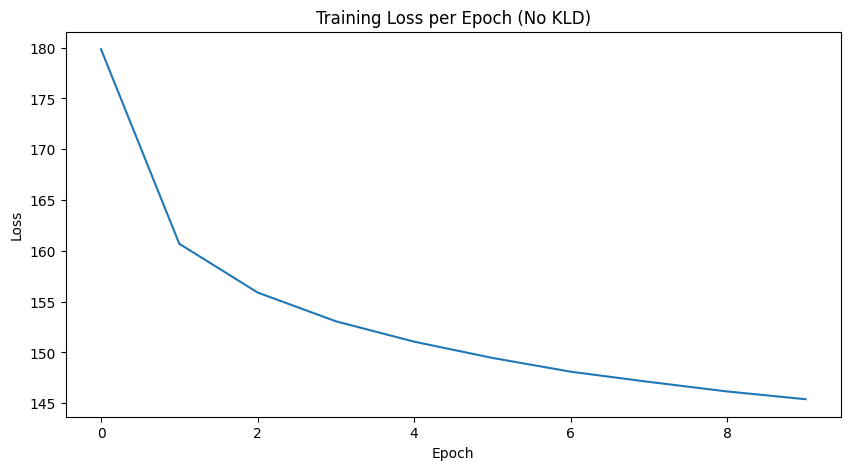

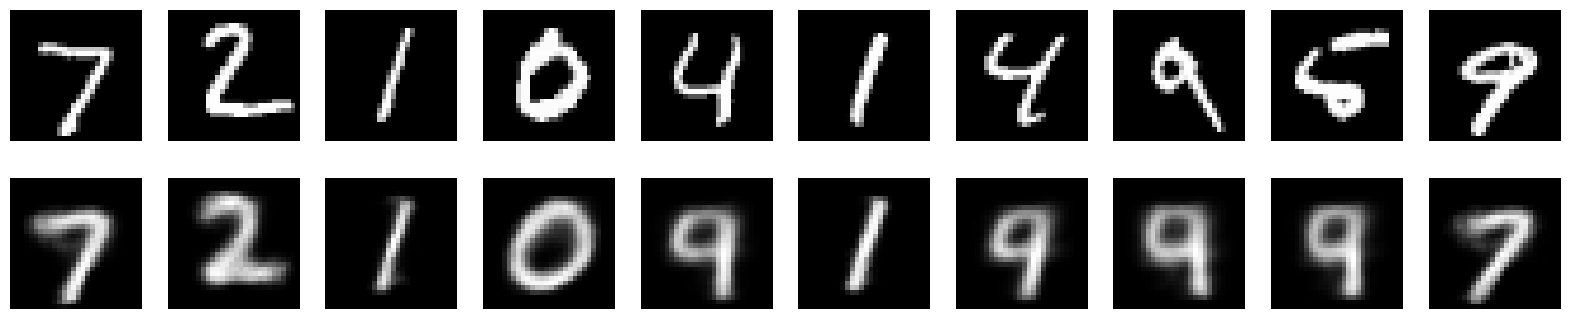

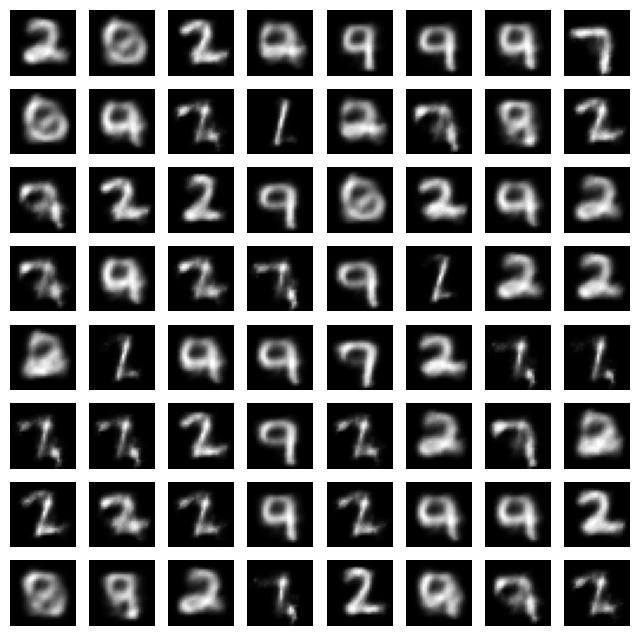

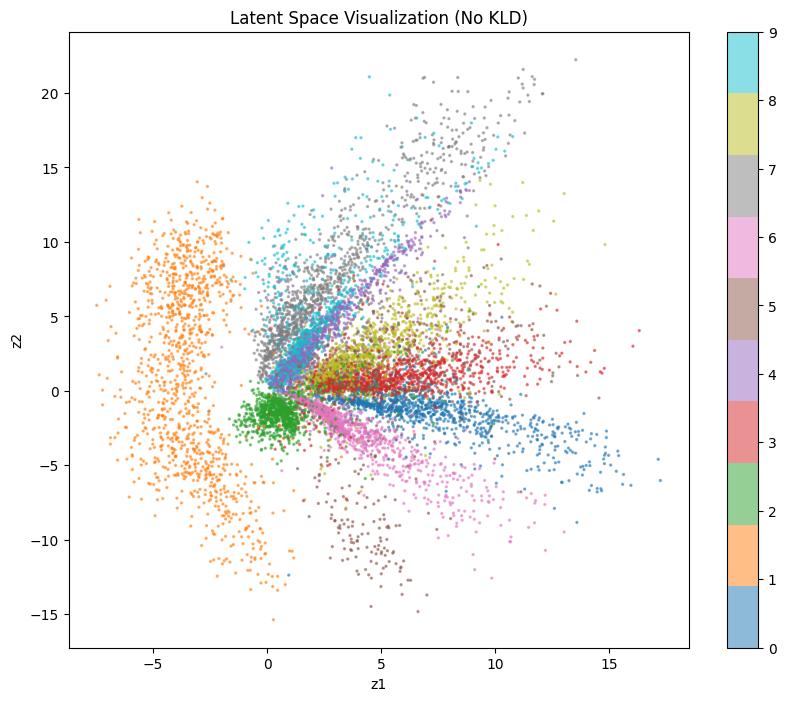

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 100
learning_rate = 1e-3
num_epochs = 10
latent_dim = 2

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2_mu = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#without kld
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return BCE

train_losses = []

model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch+1}, Average Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss per Epoch (No KLD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

model.eval()
data, _ = next(iter(test_loader))
data = data.to(device)
with torch.no_grad():
    recon, _, _ = model(data)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()

    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(sample[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

if latent_dim == 2:
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(10, 8))
    plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.5, s=2)
    plt.colorbar()
    plt.title('Latent Space Visualization (No KLD)')
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()

Epoch: 1, Average Loss: 186.5111
Epoch: 2, Average Loss: 167.3823
Epoch: 3, Average Loss: 163.3427
Epoch: 4, Average Loss: 160.8139
Epoch: 5, Average Loss: 159.1734
Epoch: 6, Average Loss: 157.8359
Epoch: 7, Average Loss: 156.6710
Epoch: 8, Average Loss: 155.8002
Epoch: 9, Average Loss: 155.0722
Epoch: 10, Average Loss: 154.3906


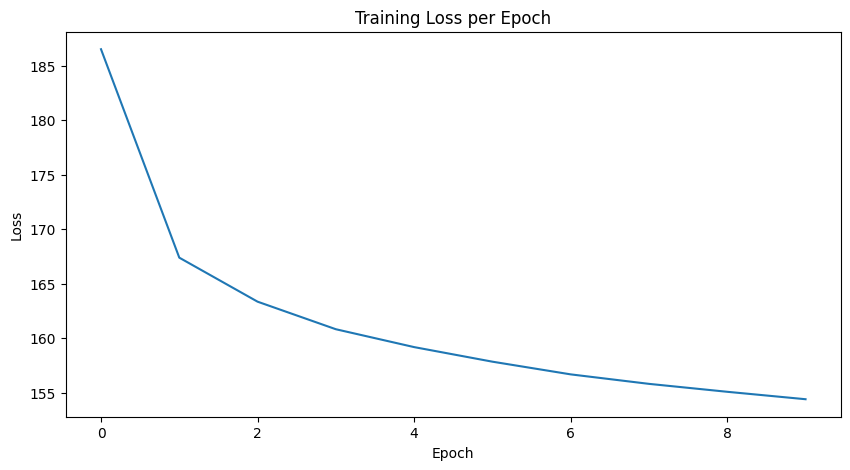

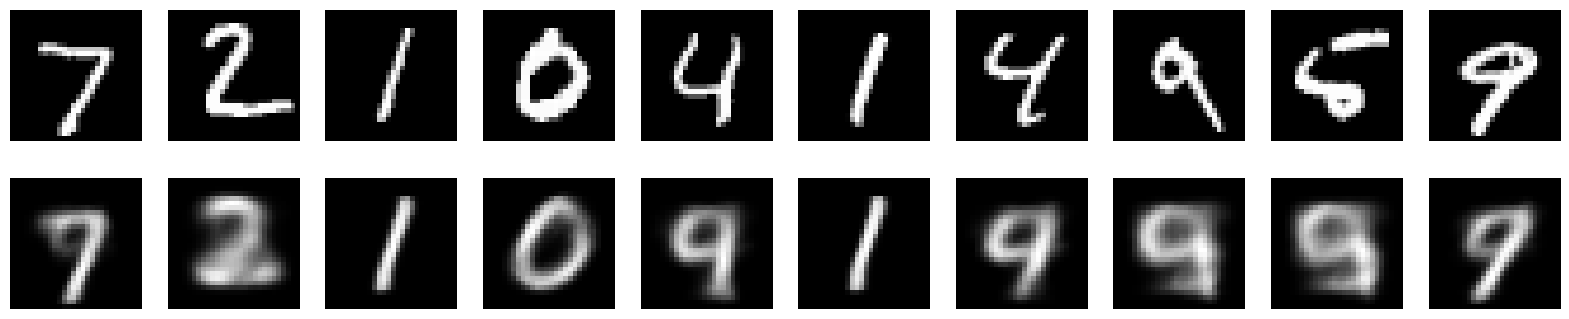

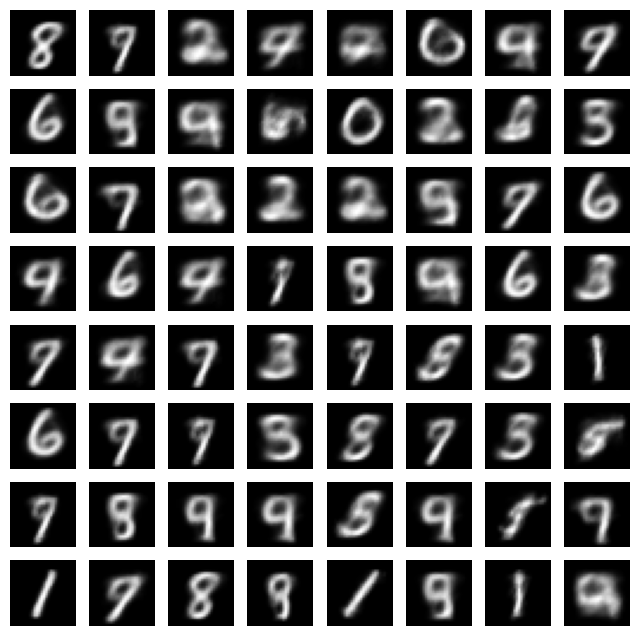

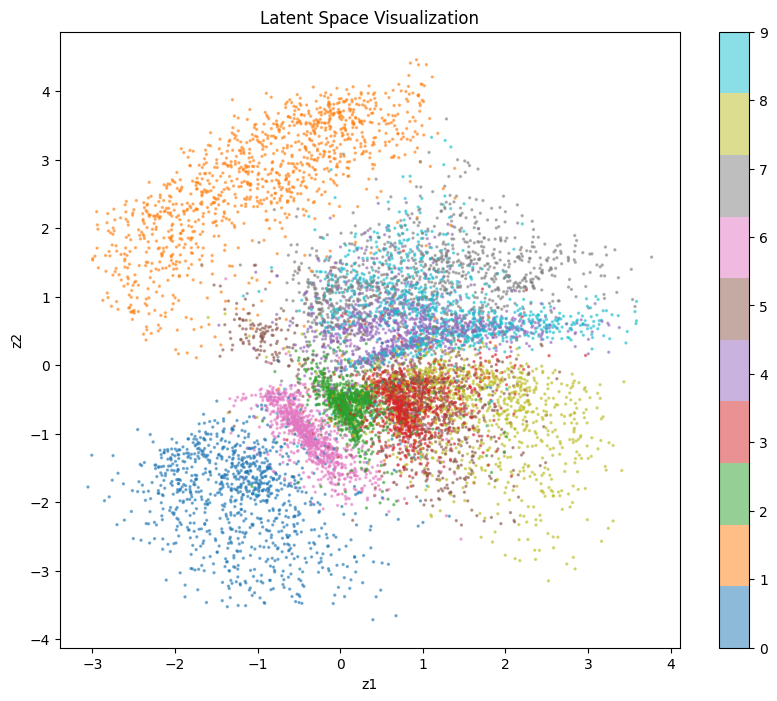

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 100
learning_rate = 1e-3
num_epochs = 10
latent_dim = 2

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2_mu = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

train_losses = []

model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch+1}, Average Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

model.eval()
data, _ = next(iter(test_loader))
data = data.to(device)
with torch.no_grad():
    recon, _, _ = model(data)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()

    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(sample[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

if latent_dim == 2:
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(10, 8))
    plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.5, s=2)
    plt.colorbar()
    plt.title('Latent Space Visualization')
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()